<a href="https://colab.research.google.com/github/JiaaiShen/MATH168_Project/blob/main/CJL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Presentation by Computational Justice Lab (CJL)

* Chencong Ren
* Joanna Shen
* Linqiao Jiang

In this notebook, we'll use a data set which includes variables about symptoms of COVID-19 patients to determine how many treatment hours they need and generate a fake data set of phyisicians and nurses to construct our network.

Let's begin by importing all the libraries that we'll need in order to run this notebook.

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
from random import randint
from itertools import combinations
import math

## Obtain and Clean Data

Run the following cell to read the data set of COVID-19 patients into Python as a `pandas` data frame called `patients_df`. 

In [ ]:
# access the data
url = "https://raw.githubusercontent.com/JiaaiShen/MATH168_Project/main/covid-19%20symptoms%20dataset.csv"
patients_df = pd.read_csv(url)
patients_df.head()

,fever,bodyPain,age,runnyNose,diffBreath,infectionProb
0,102,0,9,0,-1,0
1,102,0,10,0,0,1
2,104,0,33,1,-1,0
3,101,1,59,0,1,0
4,99,0,98,0,0,0


We want to have a basic understanding of how severe each patient's symptoms are.

Let's start by cleaning the data as follows:

*  remove the `age` column that we don't use from the data frame
*  convert the `fever` column in the data frame to 0 or 1
*  convert the `diffBreath` column in the data frame to 0 or 1



In [ ]:
# remove the age column from patients_df
patients_df = patients_df.drop(["age"], axis = 1)

In [ ]:
# loop over patients_df
for i in range(len(patients_df)):
  
  # assign new values to the fever column
  if patients_df["fever"].loc[i] < 100.4:
    patients_df.loc[i, "fever"] = 0 # 0 if the value is smaller than 100.4 degree Fahrenheit
  else:
    patients_df.loc[i, "fever"] = 1 # 1 if the value is greater than or equal to 100.4 degree Fahrenheit
  
  # assign new values to the diffBreath column
  if patients_df["diffBreath"].loc[i] == -1:
    patients_df.loc[i, "diffBreath"] = 0 # 0 if the value is equal to -1
  else:
    patients_df.loc[i, "diffBreath"] = 1 # 1 if the value is equal to 0 or 1

Now we'll find out the proportion of patients who test positive for COVID-19 having each symptom in order to compute a severity parameter for all the patients.

In [ ]:
# count how many patients test positive for COVID-19
# and create a data frame of their symptoms
positive = patients_df[patients_df["infectionProb"] == 1].drop(["infectionProb"], axis = 1)
# compute the proportion of having each symptom among the positive patients
positive.sum() / len(positive)

fever         0.568057
bodyPain      0.476790
runnyNose     0.493312
diffBreath    0.657750
dtype: float64

In [ ]:
# remove the infectionProb column from patients_df
patients_df = patients_df.drop(["infectionProb"], axis = 1)
# add a new column k to patients_df
patients_df["k"] = patients_df["fever"] * 0.568 + patients_df["bodyPain"] * 0.477 + patients_df["runnyNose"] * 0.493 + patients_df["diffBreath"] * 0.658
patients_df.head()

,fever,bodyPain,runnyNose,diffBreath,k
0,1,0,0,0,0.568
1,1,0,0,1,1.226
2,1,0,1,0,1.061
3,1,1,0,1,1.703
4,0,0,0,1,0.658


## Generate the Network

Let's do the following five steps:

0. Suppose that there are N patients (patient nodes) and they need N*k medical care units (e.g. N = 100, k = 5)
1. Suppose that there are M doctors (doctor nodes) and they can supply M*j medical care units (e.g. M = 60, j = 6) (We'll ensure that supply << demand)
2. Randomly assgin doctors to patients (edges)
3. Connect doctors who have same patient edges
4. Doctors can have collabtarions which increases medical care quality (We'll implement this later)

In [ ]:
# create network
N = 100
k = 5
M = 60
j = 6
G = nx.Graph()

In [ ]:
patient_sample = patients_df.sample(n = 100)
k_dist = list(patient_sample["k"])
k_dist = np.array(k_dist)
k_dist = k_dist * k / np.mean(k_dist)
k_dist = np.rint(k_dist).astype(int)
print(np.mean(k_dist))
print(np.sum(k_dist))

5.0
500


In [ ]:
for i in range(N):
    G.add_node(i, md_d = k_dist[i], type = "patient") # md_d = medical needed

# create doctor nodes
# suppose that each doctor's medical supply follows normal distribution (mu = 10, sd = 1)
d_dist = np.random.normal(j, 1, M)
d_dist = np.rint(d_dist).astype(int)

# some loss due to int operation
print(d_dist.mean()) # average supply
print(d_dist.sum()) # total supply
for i in range(M):
    # print(i)
    G.add_node(i + N, md_s = d_dist[i], type = "doctor") # md_d = medical needed

5.933333333333334
356


In [ ]:
# assign edges between patient and doctor
# suppose that every patient is cared by 1 - 3 doctor
# generate M random numbers whose sum is N
def randomList(m, n):
    arr = [0] * m 
    for i in range(n):
        arr[randint(0, n) % m] += 1
    return arr

for i in range(N):
    md_d = G.nodes[i]["md_d"]
    number_of_doctor = random.randint(1, 3)
    edge_weight = randomList(number_of_doctor, md_d)
    for j in range(number_of_doctor):
        G.add_edge(i, randint(N, N + M - 1), weight = edge_weight[j], type = "p-d") # patient to doctor

In [ ]:
# assign edge between doctors (who share same patient)
for i in range(N):
    # find neighbours of patient (which is doctor)
    neighbours_i = list(G.neighbors(i))
    comb = combinations(neighbours_i, 2)
    for j in comb:
        G.add_edge(j[0], j[1], type = "d-d") # doctor to doctor

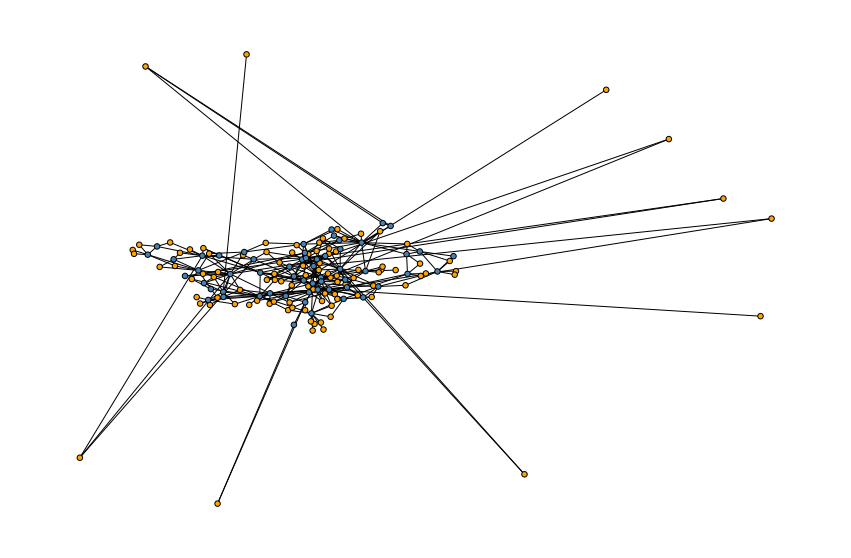

In [ ]:
Gcc = sorted(nx.connected_components(G), key = len, reverse = True)
C = G.subgraph(Gcc[0])
layout = nx.spring_layout(C)
fig, ax = plt.subplots(figsize = (15, 10))
nx.draw(C, layout,
        node_color = ["steelblue" if G.nodes[i]["type"] == "doctor" else "orange" for i in C.nodes()],
        node_size = 30
        ,edgecolors ="black")

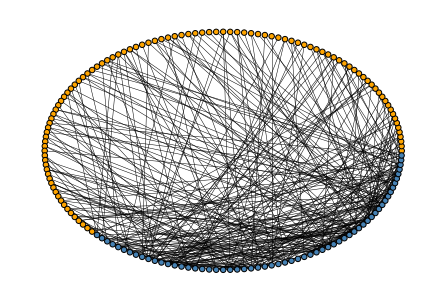

In [ ]:
layout = nx.circular_layout(G)
nx.draw(G, layout,
        node_color = ["steelblue" if G.nodes[i]["type"] == "doctor" else "orange" for i in G.nodes()],
        node_size = 30,
        edgecolors = "black",
        width = 0.5)

## Determine when collaboration can take effects

In [ ]:
# number of overloaded doctors
doctor_nodes = [i + N for i in range(M)]
overload_doctor = 0
total_over_load = 0
for i in doctor_nodes:
    workload = 0
    for j in G.edges([i]):
        if G[j[0]][j[1]]["type"] == "p-d":
            workload = workload + G[j[0]][j[1]]["weight"]
    if workload > G.nodes[i]["md_s"]:
        overload_doctor = overload_doctor + 1
        total_over_load = total_over_load + workload - G.nodes[i]["md_s"]
print("The number of overloaded doctors is :", overload_doctor)
print("The number of total overloaded units is :", total_over_load)

The number of overloaded doctors is : 32
The number of total overloaded units is : 241


In [ ]:
# decrease medical needs if there's collabration
for i in range(N + M):
  if G.nodes[i]["type"] == "patient":
    neighbours_i = list(G.neighbors(i))
    decrease = (100 - (len(neighbours_i) - 1) * 3.5) / 100

    for j in neighbours_i:
      G[i][j]["weight_after_c"] = G[i][j]["weight"] * decrease

In [ ]:
# number of overloaded doctors after considering collabration
doctor_nodes = [i + N for i in range(M)]
overload_doctor = 0
total_over_load = 0

for i in doctor_nodes:
    workload = 0
    for j in G.edges([i]):
        if G[j[0]][j[1]]["type"] == "p-d":
            workload = workload + G[j[0]][j[1]]["weight_after_c"]

    if workload > G.nodes[i]["md_s"]:
        overload_doctor = overload_doctor + 1
        total_over_load = total_over_load + workload - G.nodes[i]["md_s"]

print("The number of overloaded doctors is :", overload_doctor)
print("The number of total overloaded units is :", total_over_load)

The number of overloaded doctors is : 32
The number of total overloaded units is : 229.34500000000003


## Define a score function

In [ ]:
def score_f(G):

  num_nodes = G.number_of_nodes()
  score_list = []
  for i in range(num_nodes):
    if G.nodes[i]["type"] == "doctor":

      # calculate workload
      workload = 0

      for j in G.edges([i]):
        if G[j[0]][j[1]]["type"] == "p-d":
          workload = workload + G[j[0]][j[1]]["weight"]
      if workload > G.nodes[i]["md_s"]:
        score = (workload - G.nodes[i]["md_s"]) ** 2
        score_list.append(score)
      else:
        score = 0.2 * ((workload - G.nodes[i]["md_s"]) ** 2)
        score_list.append(score)
  score_list = np.array(score_list)
  return score_list.mean()

a = score_f(G)
print("The score of G is ", a, " and the lower the better")

The score of G is  52.94666666666667  and the lower the better


In [ ]:
# integrate collabration into score function
def score_f(G):

  num_nodes = G.number_of_nodes()
  score_list = []
  for i in range(num_nodes):
    if G.nodes[i]["type"] == "patient":
      neighbours_i = list(G.neighbors(i))
      decrease = (100 - (len(neighbours_i) - 1) * 3.5) / 100
  
      for j in neighbours_i:
        G[i][j]["weight_after_c"] = G[i][j]["weight"] * decrease

  for i in range(num_nodes):
    if G.nodes[i]["type"] == "doctor":
      # calculate workload
      workload = 0
      for j in G.edges([i]):
        if G[j[0]][j[1]]["type"] == "p-d":
          workload = workload + G[j[0]][j[1]]["weight_after_c"]
      if workload > G.nodes[i]["md_s"]:
        score = (workload - G.nodes[i]["md_s"]) ** 2
        score_list.append(score)
      else:
        score = 0.2 * ((workload - G.nodes[i]["md_s"]) ** 2)
        score_list.append(score)
  score_list = np.array(score_list)
  return score_list.mean()

a=score_f(G)
print("The score of G is ", a, " and the lower the better")

The score of G is  50.14856483333333  and the lower the better


## Design an optimization algorithm

0. Calculate score of G 
1. Find the maximum workloaded doctor D_max, and calculate the overloaded units M 
2. Find the edge e connected to D_max, whose weight is closest to M, and delete the edge e
3. Find the minimum workloaded doctor D_min and assign a new edge e' (with the same weight as e) to this D_min
4. Calculate score of the modified G'
5. Revert the change and stop if the new score is higher than the old score, otherwise save the change and repeat the previous steps 0-4

In [ ]:
def one_step_opt(G):

  num_nodes = G.number_of_nodes()
  load_dif_dict = {}
  # get weight after collabration
  for i in range(num_nodes):

    if G.nodes[i]["type"] == "patient":
      neighbours_i = list(G.neighbors(i))
      decrease = (100 - (len(neighbours_i) - 1) * 3.5) / 100

      for j in neighbours_i:
        G[i][j]["weight_after_c"] = G[i][j]["weight"] * decrease
  # calculate the difference in workload for each doctor
  for i in range(num_nodes):
    if G.nodes[i]["type"] == "doctor":
      # calculate workload
      workload = 0
      for j in G.edges([i]):
        if G[j[0]][j[1]]["type"] == "p-d":
          workload = workload + G[j[0]][j[1]]["weight_after_c"]
      unit_dif = workload - G.nodes[i]["md_s"]
      load_dif_dict[i] = unit_dif
  # most overloaded doctor
  doc_max_over = max(load_dif_dict, key = load_dif_dict.get)
  m = load_dif_dict[doc_max_over]
  # find the edge with weight closest to m
  diff_m = 999999
  edges_of_doc = []
  weight_edge = 0
  for j in G.edges([doc_max_over]):
    if G[j[0]][j[1]]["type"] == "p-d":
      if np.abs(G[j[0]][j[1]]["weight"] - m) < diff_m:
        edges_of_doc.append(j)
        weight_edge=G[j[0]][j[1]]["weight"]
  edge = edges_of_doc[-1]
  if edge[0] == doc_max_over:
    patient_n = edge[1]
  doc_min_load = min(load_dif_dict, key = load_dif_dict.get)
  if G.has_edge(patient_n, doc_min_load) or G.has_edge(doc_min_load, patient_n):
    G[patient_n][doc_min_load]["weight"] = G[patient_n][doc_min_load]["weight"] + weight_edge
  else:
    G.add_edge(patient_n, doc_min_load, weight = weight_edge, type = "p-d")
  G.remove_edge(edge[0], edge[1])

8.766843499999998


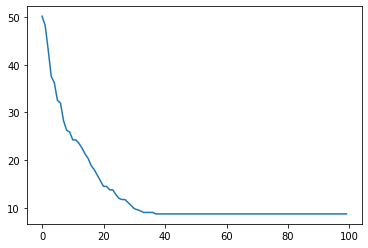

In [ ]:
H = G.copy()
score_list = []

for i in range(100):
  score_list.append(score_f(H))
  one_step_opt(H)

print(score_list[-1])
plt.plot(score_list)

In [ ]:
# redraw d-d edges
dd_edge_list = list([(u, v) for u, v , e in list(H.edges.data()) if e["type"] == "d-d"])
H.remove_edges_from(dd_edge_list)
for i in range(100):
    # find neighbours of patient (which is doctor)
    neighbours_i = list(H.neighbors(i))
    comb = combinations(neighbours_i, 2)
    for j in comb:
        H.add_edge(j[0], j[1], type = "d-d") # doctor to doctor

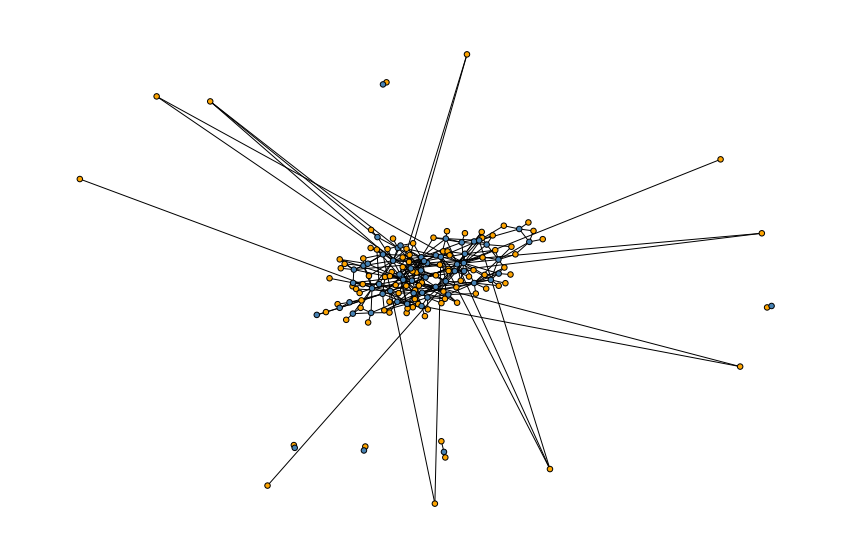

In [ ]:
layout = nx.spring_layout(H)
fig, ax = plt.subplots(figsize = (15, 10))
nx.draw(H, layout,
        node_color = ["steelblue" if H.nodes[i]["type"] == "doctor" else "orange" for i in H.nodes()],
        node_size = 30,
        edgecolors = "black")

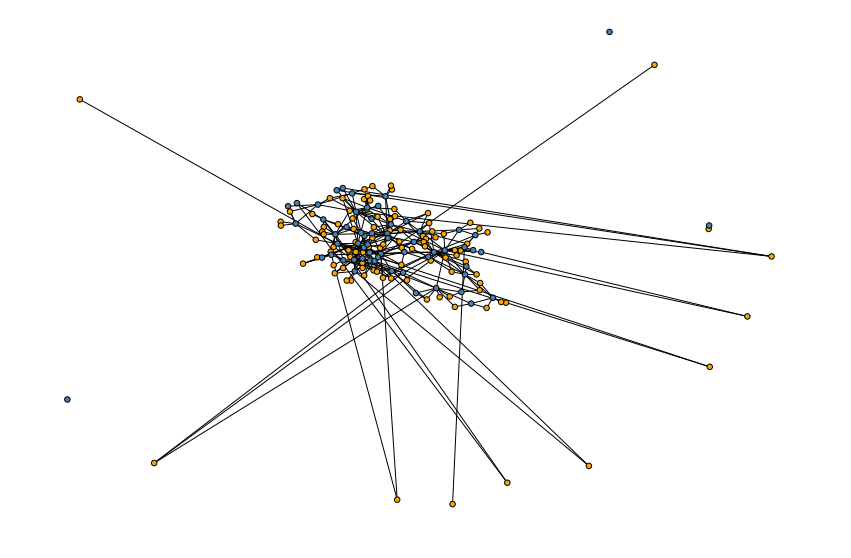

In [ ]:
layout = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (15, 10))
nx.draw(G, layout,
        node_color = ["steelblue" if G.nodes[i]["type"] == "doctor" else "orange" for i in G.nodes()],
        node_size = 30,
        edgecolors = "black")

## Implement Markov Chain Monte Carlo (MCMC)
0. Randomly choose a patient-doctor edge
1. Randomly choose a doctor
2. Try to make the change: remove old edges, add new patient-doctor edge
3. Let acceptance_prob = min(1, math.exp((old_score - new_score) * 4))
4. Filp the coin to see if we finally made this change

In [ ]:
def g_MCMC(G,score_f):
  # sample from changing edges
  M = G.copy()
  G.edges.data()
  pd_edge_list = list([(u, v) for u, v, e in list(G.edges.data()) if e["type"] == "p-d"])
  choiced_edge = random.choice(pd_edge_list)
  weight = G[choiced_edge[0]][choiced_edge[1]]["weight"]
  patient_node = choiced_edge[0] if G.nodes[choiced_edge[0]]["type"] == "patient" else choiced_edge[1]
  doctor_node = choiced_edge[1] if G.nodes[choiced_edge[1]]["type"] == "doctor" else choiced_edge[0]
  
  doctor_list = list([u for u, e in list(G.nodes.data()) if e["type"] == "doctor"])
  doctor_list.remove(doctor_node)
  choiced_doctor = random.choice(doctor_list)
  if M.has_edge(patient_node,choiced_doctor):
    M[patient_node][choiced_doctor]["weight"] = M[patient_node][choiced_doctor]["weight"] + weight
  else:
    M.add_edge(patient_node, choiced_doctor, weight = weight, type = "p-d")
  M.remove_edge(choiced_edge[0], choiced_edge[1])
  # calculate acceptance rate
  g_score = score_f(G)
  m_score = score_f(M)
  
  acceptance_prob = min(1, math.exp((g_score-m_score) * 4))

  # see if changes is accepted
  w = np.random.rand()
  if w < acceptance_prob:
    if G.has_edge(patient_node, choiced_doctor):
      G[patient_node][choiced_doctor]["weight"] = G[patient_node][choiced_doctor]["weight"] + weight
    else:
      G.add_edge(patient_node, choiced_doctor, weight = weight, type = "p-d")
    G.remove_edge(choiced_edge[0], choiced_edge[1])

9.571696666666666


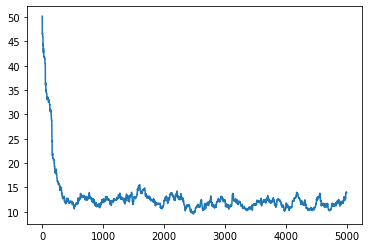

In [ ]:
H = G.copy()
score_list = []
for i in range(5000):
  score_list.append(score_f(H))
  g_MCMC(H,score_f)
  if score_f(H)<min(score_list):
    min_H=H.copy()
plt.plot(score_list)
print(min(score_list))

In [ ]:
# redraw d-d edges
dd_edge_list = list([(u, v) for u, v, e in list(min_H.edges.data()) if e["type"] == "d-d"])
min_H.remove_edges_from(dd_edge_list)

for i in range(100):
    # find neighbours of patient (which is doctor)
    neighbours_i = list(min_H.neighbors(i))
    # print(neighbours_i)
    comb = combinations(neighbours_i, 2)
    for j in comb:
        min_H.add_edge(j[0], j[1], type = "d-d") # doctor to doctor

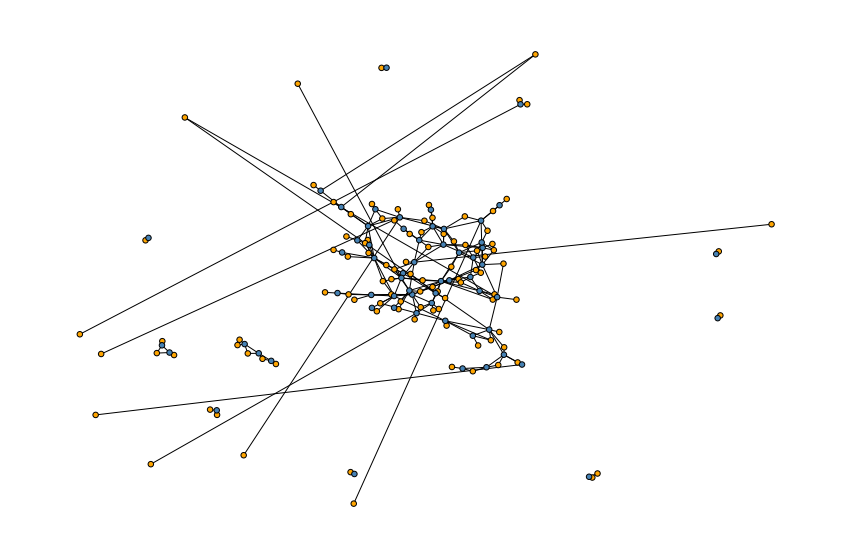

In [ ]:
layout = nx.spring_layout(min_H)
fig, ax = plt.subplots(figsize = (15, 10))
nx.draw(min_H, layout,
        node_color = ["steelblue" if min_H.nodes[i]["type"] == "doctor" else "orange" for i in min_H.nodes()],
        node_size = 30,
        edgecolors = "black")

## Implement MCMC again but with enhanced collabration


In [ ]:
def score_f(G):

  num_nodes = G.number_of_nodes()
  score_list = []
  for i in range(num_nodes):
    if G.nodes[i]["type"] == "patient":
      neighbours_i = list(G.neighbors(i))
      #
      decrease = (100 - (len(neighbours_i) - 1) * 25) / 100
  
      for j in neighbours_i:
        G[i][j]["weight_after_c"] = G[i][j]["weight"] * decrease

  for i in range(num_nodes):
    if G.nodes[i]["type"] == "doctor":
      # calculate workload
      workload = 0
      for j in G.edges([i]):
        if G[j[0]][j[1]]["type"] == "p-d":
          workload = workload + G[j[0]][j[1]]["weight_after_c"]
      if workload > G.nodes[i]["md_s"]:
        score = (workload - G.nodes[i]["md_s"]) ** 2
        score_list.append(score)
      else:
        score = 0.2 * ((workload - G.nodes[i]["md_s"]) ** 2)
        score_list.append(score)
  score_list = np.array(score_list)
  return score_list.mean()

5.7577083333333325


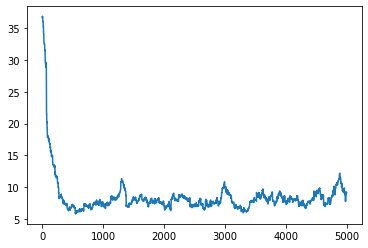

In [ ]:
H = G.copy()
score_list = []
for i in range(5000):
  score_list.append(score_f(H))
  g_MCMC(H,score_f)
  if score_f(H)<min(score_list):
    min_H=H.copy()
plt.plot(score_list)
print(min(score_list))

In [ ]:
# redraw d-d edges
dd_edge_list = list([(u, v) for u, v, e in list(min_H.edges.data()) if e["type"] == "d-d"])
min_H.remove_edges_from(dd_edge_list)

for i in range(100):
    # find neighbours of patient (which is doctor)
    neighbours_i = list(min_H.neighbors(i))
    # print(neighbours_i)
    comb = combinations(neighbours_i, 2)
    for j in comb:
        min_H.add_edge(j[0], j[1], type = "d-d") # doctor to doctor

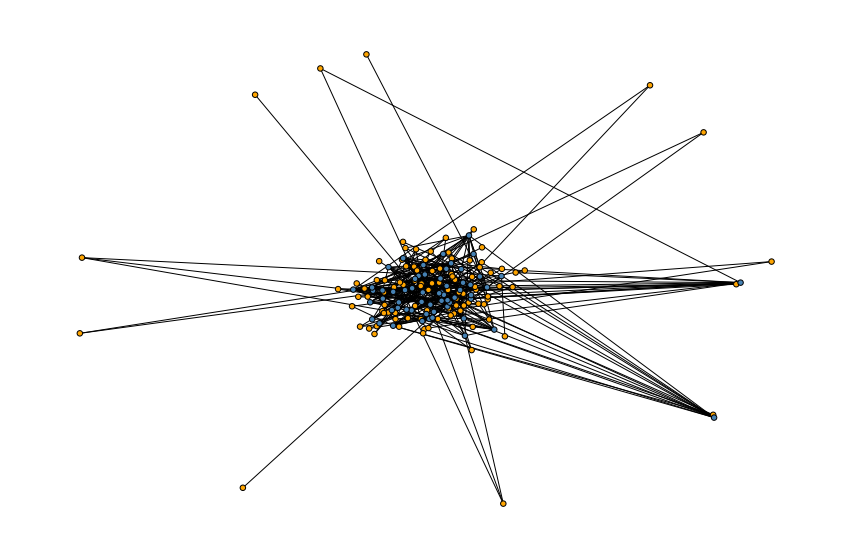

In [ ]:
layout = nx.spring_layout(H)
fig, ax = plt.subplots(figsize = (15, 10))
nx.draw(min_H, layout,
        node_color = ["steelblue" if min_H.nodes[i]["type"] == "doctor" else "orange" for i in min_H.nodes()],
        node_size = 30,
        edgecolors = "black")

## Next Steps

Our final goal is to optimize the newly generated network that eventually adds new healthcare workers (doctors & nurses) nodes. Since we have completed the optimization of our initial network, we will add new nodes and continue to optimize the newly generated network according to our algorithm.

## Introspection

-	Our healthcare network is based on a random dataset we obtained from Kaggle. We hope that we can get more real and larger medical data set to grow into our network in the future

-	The penalty function in our score function is defined by ourselves based on the actual situation. However, we still need to collect some actual medical data to help us validate this design

-	Collaboration coefficient in our code was defined by ourselves, and we will find relevant literature to find out what parameters will make more sense